In [1]:
from __future__ import annotations
import numpy as np
from typing import *
import copy
import scipy.stats as stats
import matplotlib.pyplot as plt

In [39]:
class MetricCollector:
    def __init__(self):
        self.best_individual_cost_each_gen = []
        self.avg_cost_each_gen = []

        self.best_elite_individual_cost_each_gen = []
        self.avg_elite_cost_each_gen = []

        self.best_middle_individual_cost_each_gen = []
        self.avg_middle_cost_each_gen = []

        self.best_lower_individual_cost_each_gen = []
        self.avg_lower_cost_each_gen = []

    def collect_all(self, best_individual_fitness: float, avg_fitness: float):
        self.best_individual_cost_each_gen.append(best_individual_fitness)
        self.avg_cost_each_gen.append(avg_fitness)

    def collect_elite(self, best_individual_fitness: float, avg_fitness: float):
        self.best_elite_individual_cost_each_gen.append(best_individual_fitness)
        self.avg_elite_cost_each_gen.append(avg_fitness)

    def collect_middle(self, best_individual_fitness: float, avg_fitness: float):
        self.best_middle_individual_cost_each_gen.append(best_individual_fitness)
        self.avg_middle_cost_each_gen.append(avg_fitness)

    def collect_lower(self, best_individual_fitness: float, avg_fitness: float):
        self.best_lower_individual_cost_each_gen.append(best_individual_fitness)
        self.avg_lower_cost_each_gen.append(avg_fitness)

    def compile_graphs(self):
        # make subplot for 4 graphs
        fig, axs = plt.subplots(2, 2)
        fig.suptitle('DE Metrics')
        # plot best individual cost
        axs[0, 0].plot(self.best_individual_cost_each_gen, label="Best Individual")
        axs[0, 0].plot(self.avg_cost_each_gen, label="Average")
        axs[0, 0].set_title("All")
        axs[0, 0].legend()
        # plot best elite individual cost
        axs[0, 1].plot(self.best_elite_individual_cost_each_gen, label="Best Individual")
        axs[0, 1].plot(self.avg_elite_cost_each_gen, label="Average")
        axs[0, 1].set_title("Elite")
        axs[0, 1].legend()
        # plot best middle individual cost
        axs[1, 0].plot(self.best_middle_individual_cost_each_gen, label="Best Individual")
        axs[1, 0].plot(self.avg_middle_cost_each_gen, label="Average")
        axs[1, 0].set_title("Middle")
        axs[1, 0].legend()
        # plot best lower individual cost
        axs[1, 1].plot(self.best_lower_individual_cost_each_gen, label="Best Individual")
        axs[1, 1].plot(self.avg_lower_cost_each_gen, label="Average")
        axs[1, 1].set_title("Lower")
        axs[1, 1].legend()
        # show the plot
        # increase plot size
        fig.set_size_inches(18.5, 10.5)
        plt.show()

In [3]:
def bound_applier(
    x: np.ndarray,
    bounds: List[Tuple]
):
    bounded = np.zeros_like(x)
    for i in range(len(x)):
        bounded[i] = x[i] * (bounds[i][1] - bounds[i][0]) + bounds[i][0]
    return bounded

def latin_hyper_cube_initializer(dimension: int, population_size: int, bounds: List[Tuple], seed: int = 0) -> np.ndarray:
    lsh_sampler = stats.qmc.LatinHypercube(d=dimension, seed=seed)
    sample = lsh_sampler.random(n=population_size)
    bounded = np.apply_along_axis(
        lambda x: bound_applier(x, bounds),
        1,
        sample
    )
    return bounded

In [4]:
def rand_1_2_pop_bin_mutator(
    population1: np.ndarray,
    population2: np.ndarray,
    differential_factor: float,
    f: Callable
):
    x1, x2 = np.random.choice(population1.shape[0], 2, replace=False)
    x3 = np.random.choice(population2.shape[0])
    target_vector = population1[x1]
    mutant_vector = target_vector + differential_factor * (population1[x2] - population2[x3])
    return target_vector, mutant_vector

def rand_2_3_pop_bin_mutator(
    population1: np.ndarray,
    population2: np.ndarray,
    population3: np.ndarray,
    differential_factor: float,
    f: Callable
):
    x1 = np.random.choice(population1.shape[0])
    x2, x3 = np.random.choice(population2.shape[0], 2, replace=False)
    x4, x5 = np.random.choice(population3.shape[0], 2, replace=False)
    target_vector = population1[x1]
    mutant_vector = target_vector + differential_factor * (population2[x2] - population2[x3] + population3[x4] - population3[x5])
    return target_vector, mutant_vector

def binomial_crossover(
    target_vector: np.ndarray,
    mutant_vector: np.ndarray,
    crossover_prob: float
):
    crossover = np.zeros_like(target_vector)
    for i in range(len(target_vector)):
        if np.random.rand() < crossover_prob:
            crossover[i] = mutant_vector[i]
        else:
            crossover[i] = target_vector[i]
    return crossover

In [225]:
def two_way_merge_sorted_array(
    population1: np.ndarray,
    population1_val: np.ndarray,
    population2: np.ndarray,
    population2_val: np.ndarray,
    merge_size: int,
):
    merged = np.zeros((merge_size, population1.shape[1]))
    merged_val = np.zeros(merge_size)
    i = 0
    j = 0
    k = 0
    while i < population1.shape[0] and j < population2.shape[0] and k < merge_size:
        if population1_val[i] < population2_val[j]:
            merged[k] = population1[i]
            merged_val[k] = population1_val[i]
            i += 1
        else:
            merged[k] = population2[j]
            merged_val[k] = population2_val[j]
            j += 1
        k += 1
    return merged, merged_val, population1[i:], population2[j:], population1_val[i:], population2_val[j:], i, j

def ttp_de(
    f: Callable,
    pop_initializer: Callable[[int], np.ndarray],
    elite_pop_size: int,
    middle_pop_size: int,
    lower_pop_size: int,
    F1: float,
    F2: float,
    F3: float,
    T: float,
    alpha: float,
    crossover_prob: float,
    crossover_func: Callable[[np.ndarray, np.ndarray, float], np.ndarray],
    n_iter: int,
    metric: MetricCollector = MetricCollector()
):
    elite_pop = pop_initializer(elite_pop_size)
    middle_pop = pop_initializer(middle_pop_size)
    lower_pop = pop_initializer(lower_pop_size)

    for i in range(n_iter):
        if i % 10 == 0:
            T *= alpha
            print(f"Iteration {i}: {f(elite_pop[0])} {T} {alpha}")
        elitist_offspring = []
        middle_offspring = []
        lower_offspring = []

        for j in range(elite_pop_size):
            target_vector, mutant_vector = rand_1_2_pop_bin_mutator(elite_pop, elite_pop, F1, f)
            crossover = crossover_func(target_vector, mutant_vector, crossover_prob)
            elitist_offspring.append(crossover)

        for j in range(middle_pop_size//4):
            target_vector, mutant_vector = rand_1_2_pop_bin_mutator(elite_pop, middle_pop, F2, f)
            crossover = crossover_func(target_vector, mutant_vector, crossover_prob)
            middle_offspring.append(crossover)

        for j in range(middle_pop_size//4):
            target_vector, mutant_vector = rand_1_2_pop_bin_mutator(middle_pop, middle_pop, F2, f)
            crossover = crossover_func(target_vector, mutant_vector, crossover_prob)
            middle_offspring.append(crossover)

        for j in range(middle_pop_size//4):
            target_vector, mutant_vector = rand_1_2_pop_bin_mutator(middle_pop, lower_pop, F2, f)
            crossover = crossover_func(target_vector, mutant_vector, crossover_prob)
            middle_offspring.append(crossover)

        for j in range(middle_pop_size//4):
            target_vector, mutant_vector = rand_2_3_pop_bin_mutator(elite_pop, middle_pop, lower_pop, F2, f)
            crossover = crossover_func(target_vector, mutant_vector, crossover_prob)
            middle_offspring.append(crossover)

        for j in range(lower_pop_size//4):
            target_vector, mutant_vector = rand_1_2_pop_bin_mutator(elite_pop, lower_pop, F3, f)
            crossover = crossover_func(target_vector, mutant_vector, crossover_prob)
            lower_offspring.append(crossover)

        for j in range(lower_pop_size//4):
            target_vector, mutant_vector = rand_1_2_pop_bin_mutator(lower_pop, lower_pop, F3, f)
            crossover = crossover_func(target_vector, mutant_vector, crossover_prob)
            lower_offspring.append(crossover)

        elite_pop_all = np.concatenate((elite_pop, np.array(elitist_offspring)), dtype=np.float64)
        elite_pop_val = np.apply_along_axis(f, 1, elite_pop_all)
        elite_pop_sorted_ind = np.argsort(elite_pop_val)

        middle_pop_all = np.concatenate((middle_pop, np.array(middle_offspring)), dtype=np.float64)
        middle_pop_val = np.apply_along_axis(f, 1, middle_pop_all)
        middle_pop_sorted_ind = np.argsort(middle_pop_val)

        lower_pop_all = np.concatenate((lower_pop, np.array(lower_offspring)), dtype=np.float64)
        lower_pop_val = np.apply_along_axis(f, 1, lower_pop_all)
        lower_pop_sorted_ind = np.argsort(lower_pop_val)

        elite_merged, elite_merged_val, elite_leftover, middle_leftover, elite_leftover_val, middle_leftover_val, elite_i, middle_j = two_way_merge_sorted_array(
            elite_pop_all[elite_pop_sorted_ind[:elite_pop_size]],
            elite_pop_val[elite_pop_sorted_ind[:elite_pop_size]],
            middle_pop_all[middle_pop_sorted_ind[:middle_pop_size]],
            middle_pop_val[middle_pop_sorted_ind[:middle_pop_size]],
            elite_pop_size
        )

        middle = elite_leftover
        num_left_to_select = middle_pop_size - middle.shape[0] + lower_pop_size // 2
        num_left_middle = middle_pop_size - middle.shape[0]
        lowest_middle_val = f(middle[-1]) if middle.shape[0] > 0 else np.inf
        leftover_ind = np.concatenate((middle_pop_sorted_ind[middle_j:], (middle_pop_sorted_ind.shape[0] - middle_j) + lower_pop_sorted_ind))
        leftover_val = np.concatenate((middle_pop_val[middle_pop_sorted_ind[middle_j:]], lower_pop_val[lower_pop_sorted_ind]))
        leftover_pop = np.concatenate((middle_pop_all[middle_pop_sorted_ind[middle_j:]], lower_pop_all[lower_pop_sorted_ind]))
        leftover_select = []

        while len(leftover_select) < num_left_to_select:
            i = np.random.choice(leftover_ind) - 1
            delta = leftover_val[i] - lowest_middle_val
            if np.random.rand() < np.exp(-delta / T):
                lowest_middle_val = leftover_val[i]
                leftover_select.append(i)

        selected_leftover = np.array(leftover_pop[leftover_select])
        selected_leftover_sorted = selected_leftover[np.argsort(np.apply_along_axis(f, 1, selected_leftover))]
        elite_pop = elite_merged
        middle_pop = np.concatenate((middle, selected_leftover_sorted[:num_left_middle]))
        lower_pop = np.concatenate((selected_leftover_sorted[num_left_middle:], pop_initializer(lower_pop_size - selected_leftover_sorted.shape[0] + num_left_middle)))

        elite_pop_val = elite_merged_val
        middle_pop_val = np.concatenate((elite_leftover_val, leftover_val[leftover_select][:num_left_middle]))
        lower_pop_val = leftover_val[leftover_select][num_left_middle:]
        all_val = np.concatenate((elite_pop_val, middle_pop_val, lower_pop_val))

        metric.collect_all(f(elite_pop[0]), np.mean(all_val))
        metric.collect_elite(f(elite_pop[0]), np.mean(elite_pop_val))
        metric.collect_middle(f(elite_pop[0]), np.mean(middle_pop_val))
        metric.collect_lower(f(elite_pop[0]), np.mean(lower_pop_val))

        # selection
        # pop_all = np.concatenate((elite_pop, middle_pop, lower_pop, np.array(elitist_offspring), np.array(middle_offspring), np.array(lower_offspring)))
        # pop_all_val: np.ndarray = np.apply_along_axis(f, 1, pop_all)
        # pop_all_sorted_ind = np.argsort(pop_all_val)
        # elite_pop = pop_all[pop_all_sorted_ind[:elite_pop_size]]
        # middle_pop = pop_all[pop_all_sorted_ind[elite_pop_size:elite_pop_size+middle_pop_size]]
        # lower_pop = pop_all[pop_all_sorted_ind[elite_pop_size+middle_pop_size:elite_pop_size+middle_pop_size+lower_pop_size//2]]
        # lower_pop = np.concatenate((lower_pop, pop_initializer(lower_pop_size-len(lower_pop))))
        #
        # metric.collect_all(f(elite_pop[0]), np.mean(pop_all_val))
        # metric.collect_elite(f(elite_pop[0]), np.mean(pop_all_val[:elite_pop_size]))
        # metric.collect_middle(f(elite_pop[0]), np.mean(pop_all_val[elite_pop_size:elite_pop_size+middle_pop_size]))
        # metric.collect_lower(f(elite_pop[0]), np.mean(pop_all_val[elite_pop_size+middle_pop_size:elite_pop_size+middle_pop_size+lower_pop_size//2]))

    best_index = np.argmin(np.apply_along_axis(f, 1, elite_pop))
    best = elite_pop[best_index]
    best_val = f(best)
    return best, best_val

Iteration 0: 19.750933035888373 50.0 0.5
Iteration 10: 0.004512957048918546 25.0 0.5
Iteration 20: 2.76168193724497e-06 12.5 0.5
Iteration 30: 3.5822281600086264e-08 6.25 0.5
Iteration 40: 1.8486662115343971e-10 3.125 0.5
Iteration 50: 2.739576608498658e-13 1.5625 0.5
Iteration 60: 4.674942802036062e-16 0.78125 0.5
Iteration 70: 8.758569928882848e-19 0.390625 0.5
Iteration 80: 2.007464378804249e-21 0.1953125 0.5
Iteration 90: 2.6110881783752904e-23 0.09765625 0.5


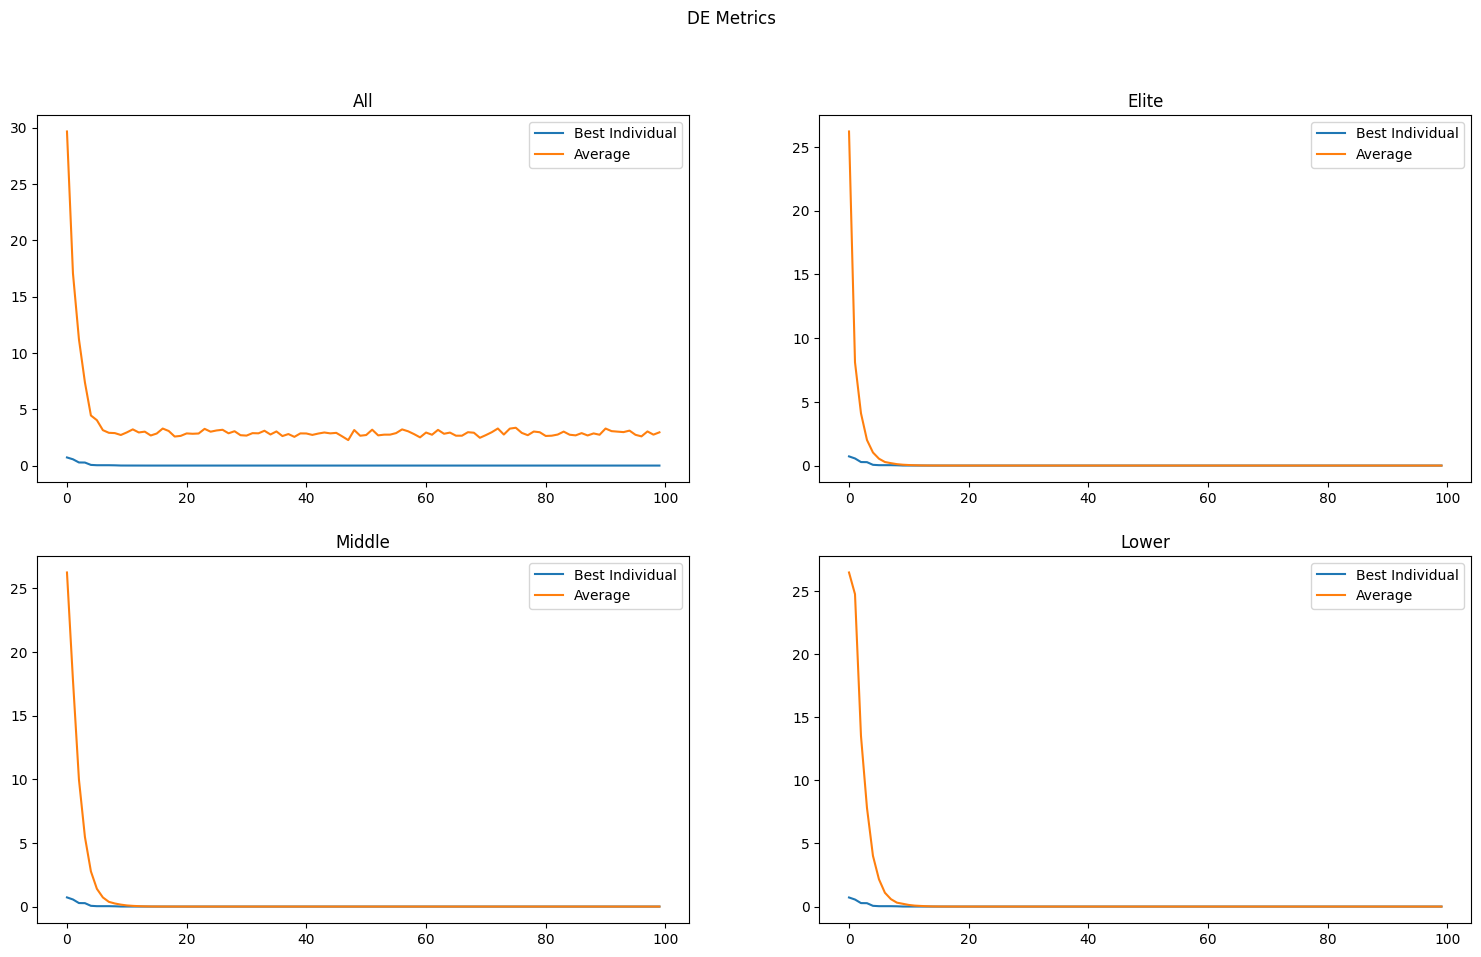

(array([1.96935549e-14, 2.33735118e-13, 6.81244121e-15]),
 5.506635077421684e-26)

In [226]:
def func_1(x: np.ndarray):
    return x[0] ** 2 + x[1] ** 2 + x[2] ** 2

def latin(d: int, bounds):
    return lambda x: latin_hyper_cube_initializer(d, x, bounds, 0)

metric_1 = MetricCollector()
elite_pop_size = 50
middle_pop_size = 100
lower_pop_size = 50
F1 = 0.3
F2 = 0.5
F3 = 0.7
bounds = [(-5.12, 5.12) for _ in range(3)]
n_iters = 100

res = ttp_de(
    f=func_1,
    elite_pop_size=elite_pop_size,
    middle_pop_size=middle_pop_size,
    lower_pop_size=lower_pop_size,
    pop_initializer=latin(3, bounds),
    F1=F1,
    F2=F2,
    F3=F3,
    crossover_prob=0.5,
    crossover_func=binomial_crossover,
    n_iter=n_iters,
    metric=metric_1,
    T=100,
    alpha=0.5
)
metric_1.compile_graphs()
res

Iteration 0: 509981.34203254536 450.0 0.9
Iteration 10: 220673.05534622402 405.0 0.9
Iteration 20: 106027.05511052342 364.5 0.9
Iteration 30: 55339.4625257828 328.05 0.9
Iteration 40: 26744.73263889323 295.245 0.9
Iteration 50: 16218.943941594343 265.7205 0.9
Iteration 60: 10399.532848415116 239.14845000000003 0.9
Iteration 70: 5875.608248529141 215.23360500000004 0.9
Iteration 80: 3338.3545863133068 193.71024450000004 0.9
Iteration 90: 1612.7645577424698 174.33922005000005 0.9
Iteration 100: 871.1117370766186 156.90529804500005 0.9
Iteration 110: 413.15228475209517 141.21476824050006 0.9
Iteration 120: 245.50801046925787 127.09329141645006 0.9
Iteration 130: 158.8385229937327 114.38396227480506 0.9
Iteration 140: 74.17815449075933 102.94556604732455 0.9
Iteration 150: 35.95667471225757 92.6510094425921 0.9
Iteration 160: 16.99921492902846 83.3859084983329 0.9
Iteration 170: 9.032501862162134 75.04731764849961 0.9
Iteration 180: 5.153935339985652 67.54258588364965 0.9
Iteration 190: 2.

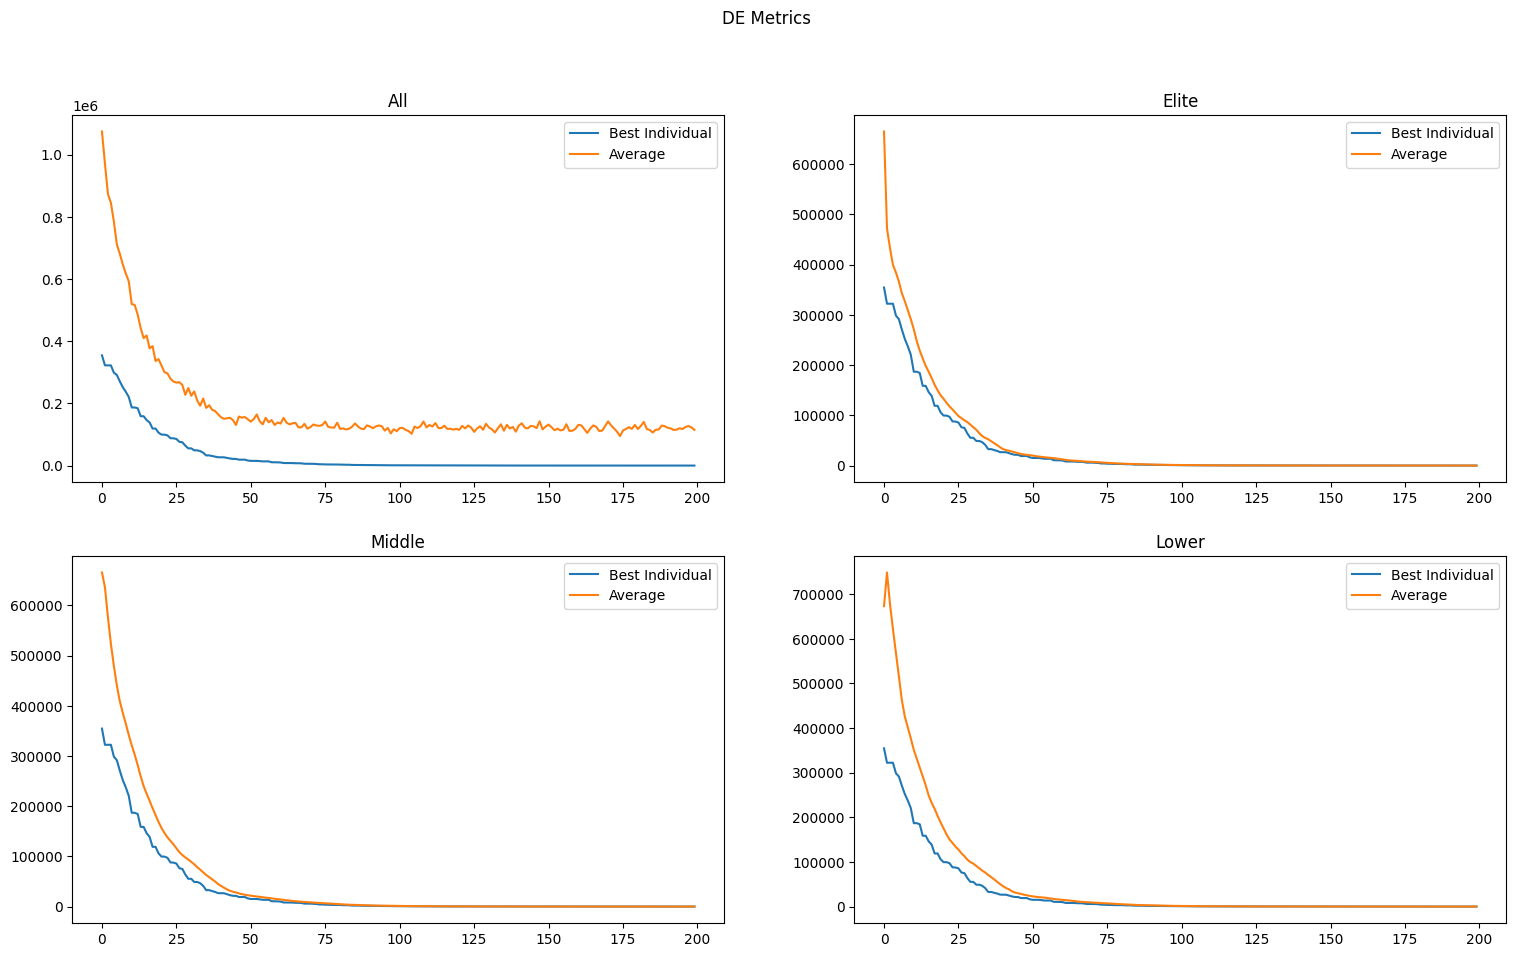

(array([-0.02027811,  0.01552129, -0.02394361,  0.03982899, -0.0121819 ,
         0.01216068, -0.07770614, -0.02619738,  0.01292727, -0.03181344,
         0.08719175, -0.0176459 ,  0.04400654,  0.07746544,  0.0281634 ,
        -0.04396381,  0.07428711, -0.01590346,  0.06088337,  0.14758641,
        -0.07355213,  0.0957208 ,  0.0204149 , -0.09703283,  0.14513979,
        -0.10880092,  0.01073534, -0.01465635, -0.08225168,  0.10804772]),
 1.3902395209035747)

In [227]:
def func_5(x: np.ndarray):
    cost = 0
    for i in range(30):
        for j in range(i + 1):
            cost += x[j] ** 2
    return cost

metric_5 = MetricCollector()
bounds = [(-65.536, 65.536) for _ in range(30)]
d = 30
elite_pop_size = 50
middle_pop_size = 200
lower_pop_size = 50
F1 = 0.1
F2 = 1
F3 = 2
n_iters = 200
res = ttp_de(
    f=func_5,
    elite_pop_size=elite_pop_size,
    middle_pop_size=middle_pop_size,
    lower_pop_size=lower_pop_size,
    pop_initializer=latin(d, bounds),
    F1=F1,
    F2=F2,
    F3=F3,
    crossover_prob=0.5,
    crossover_func=binomial_crossover,
    n_iter=n_iters,
    metric=metric_5,
    T=500,
    alpha=0.9
)
metric_5.compile_graphs()
res

Iteration 0: 18726.555623692977 450.0 0.9
Iteration 10: 1978.3740651549938 405.0 0.9
Iteration 20: 700.382299805222 364.5 0.9
Iteration 30: 358.75564622097767 328.05 0.9
Iteration 40: 268.3130913997677 295.245 0.9
Iteration 50: 192.24605227248935 265.7205 0.9
Iteration 60: 147.69522518739913 239.14845000000003 0.9
Iteration 70: 94.65917888467959 215.23360500000004 0.9
Iteration 80: 61.87503841112383 193.71024450000004 0.9
Iteration 90: 41.41592533058141 174.33922005000005 0.9
Iteration 100: 32.79564529227065 156.90529804500005 0.9
Iteration 110: 29.609814390418943 141.21476824050006 0.9
Iteration 120: 28.24313174100342 127.09329141645006 0.9
Iteration 130: 27.604098711856473 114.38396227480506 0.9
Iteration 140: 27.343633367987184 102.94556604732455 0.9
Iteration 150: 27.129788194419678 92.6510094425921 0.9
Iteration 160: 26.9996746671993 83.3859084983329 0.9
Iteration 170: 26.87923587323007 75.04731764849961 0.9
Iteration 180: 26.75169269500904 67.54258588364965 0.9
Iteration 190: 26.

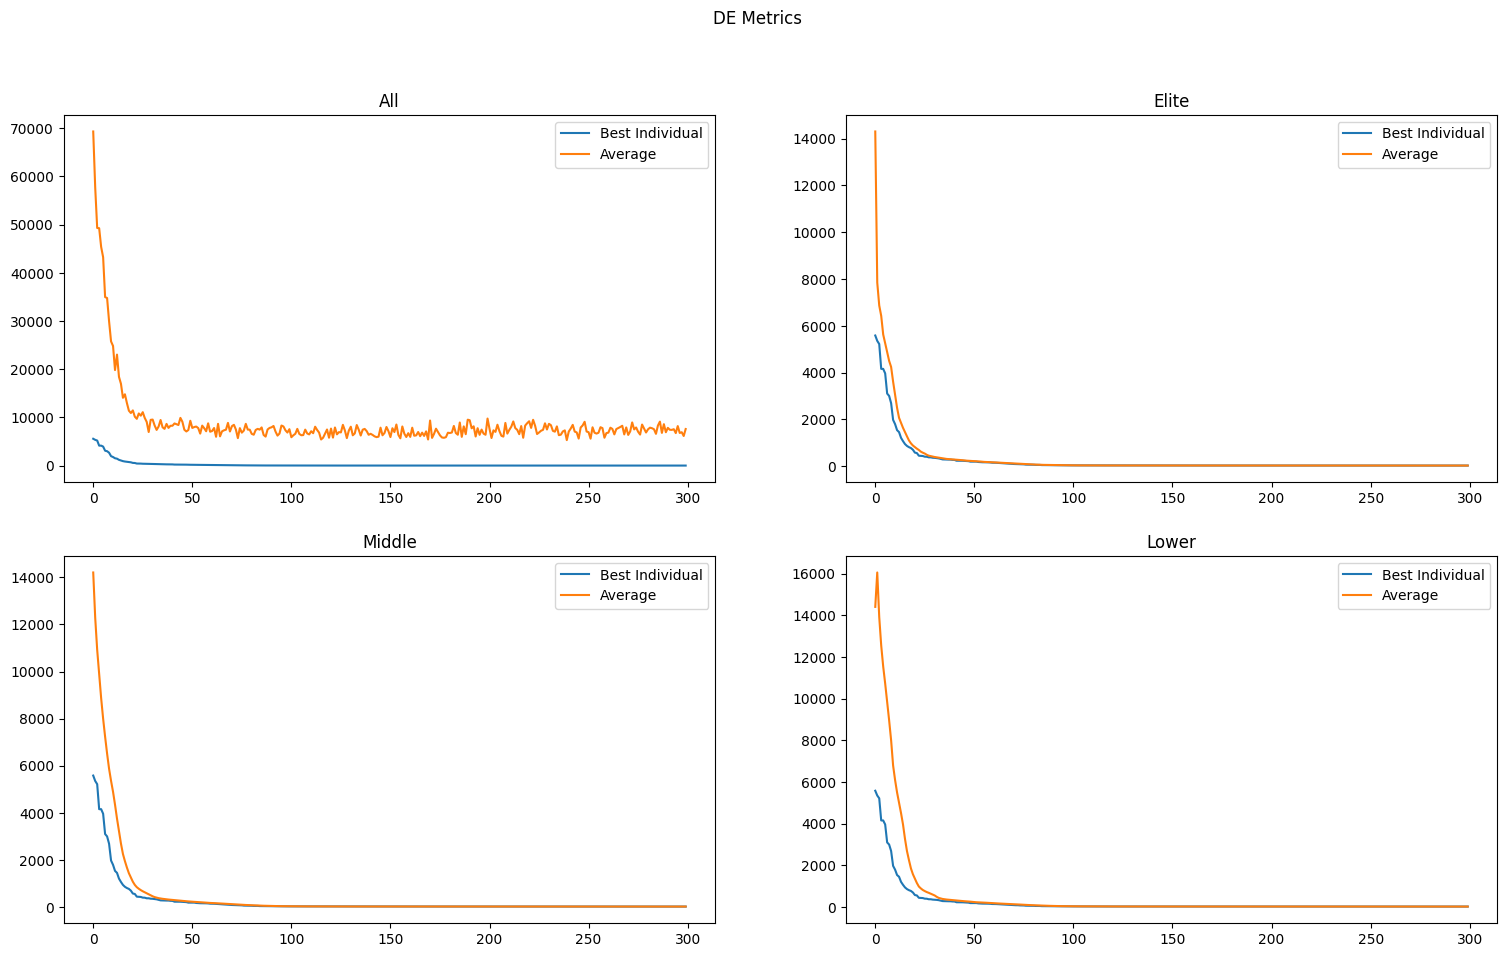

(array([ 0.92825105,  0.85787179,  0.74195437,  0.55353587,  0.31703024,
         0.10496977,  0.02041815,  0.01282281,  0.0249368 ,  0.00785903,
         0.01277082,  0.01422293,  0.01460053,  0.01165522,  0.00457321,
         0.01257565,  0.00651126,  0.01156342,  0.01345646,  0.01172491,
         0.01898276, -0.00254676,  0.01150177,  0.01068444,  0.01227827,
         0.00783363,  0.0011034 ,  0.00677211,  0.00425471,  0.00297751]),
 24.395913717443978)

In [228]:
def func_6(x: np.ndarray):
    cost = 0
    for i in range(29):
        cost += 100 * (x[i+1] - x[i]**2)**2 + (1 - x[i])**2
    return cost

metric_6 = MetricCollector()
bounds = [(-2.048, 2.048) for _ in range(30)]
d = 30
n_iters = 300
elite_pop_size = 30
middle_pop_size = 170
lower_pop_size = 100
F1 = 0.2
F2 = 1
F3 = 1.5
res = ttp_de(
    f=func_6,
    elite_pop_size=elite_pop_size,
    middle_pop_size=middle_pop_size,
    lower_pop_size=lower_pop_size,
    pop_initializer=latin(d, bounds),
    F1=F1,
    F2=F2,
    F3=F3,
    crossover_prob=0.5,
    crossover_func=binomial_crossover,
    n_iter=n_iters,
    metric=metric_6,
    T=500,
    alpha=0.9
)
metric_6.compile_graphs()
res

Iteration 0: 3341.026939283623 450.0 0.9
Iteration 10: 1165.4896868037579 405.0 0.9
Iteration 20: 605.1729940137699 364.5 0.9
Iteration 30: 401.1823444424559 328.05 0.9
Iteration 40: 273.1574542099994 295.245 0.9
Iteration 50: 234.80179043484557 265.7205 0.9
Iteration 60: 187.7371313901391 239.14845000000003 0.9
Iteration 70: 154.0546925653707 215.23360500000004 0.9
Iteration 80: 135.16670897203343 193.71024450000004 0.9
Iteration 90: 117.82017263771081 174.33922005000005 0.9
Iteration 100: 104.70709272449552 156.90529804500005 0.9
Iteration 110: 93.06792006524469 141.21476824050006 0.9
Iteration 120: 81.96765459091552 127.09329141645006 0.9
Iteration 130: 72.65630133270996 114.38396227480506 0.9
Iteration 140: 66.09061524570784 102.94556604732455 0.9
Iteration 150: 58.49213116886465 92.6510094425921 0.9
Iteration 160: 52.06586373992605 83.3859084983329 0.9
Iteration 170: 46.60687692889377 75.04731764849961 0.9
Iteration 180: 42.43354749403049 67.54258588364965 0.9
Iteration 190: 37.19

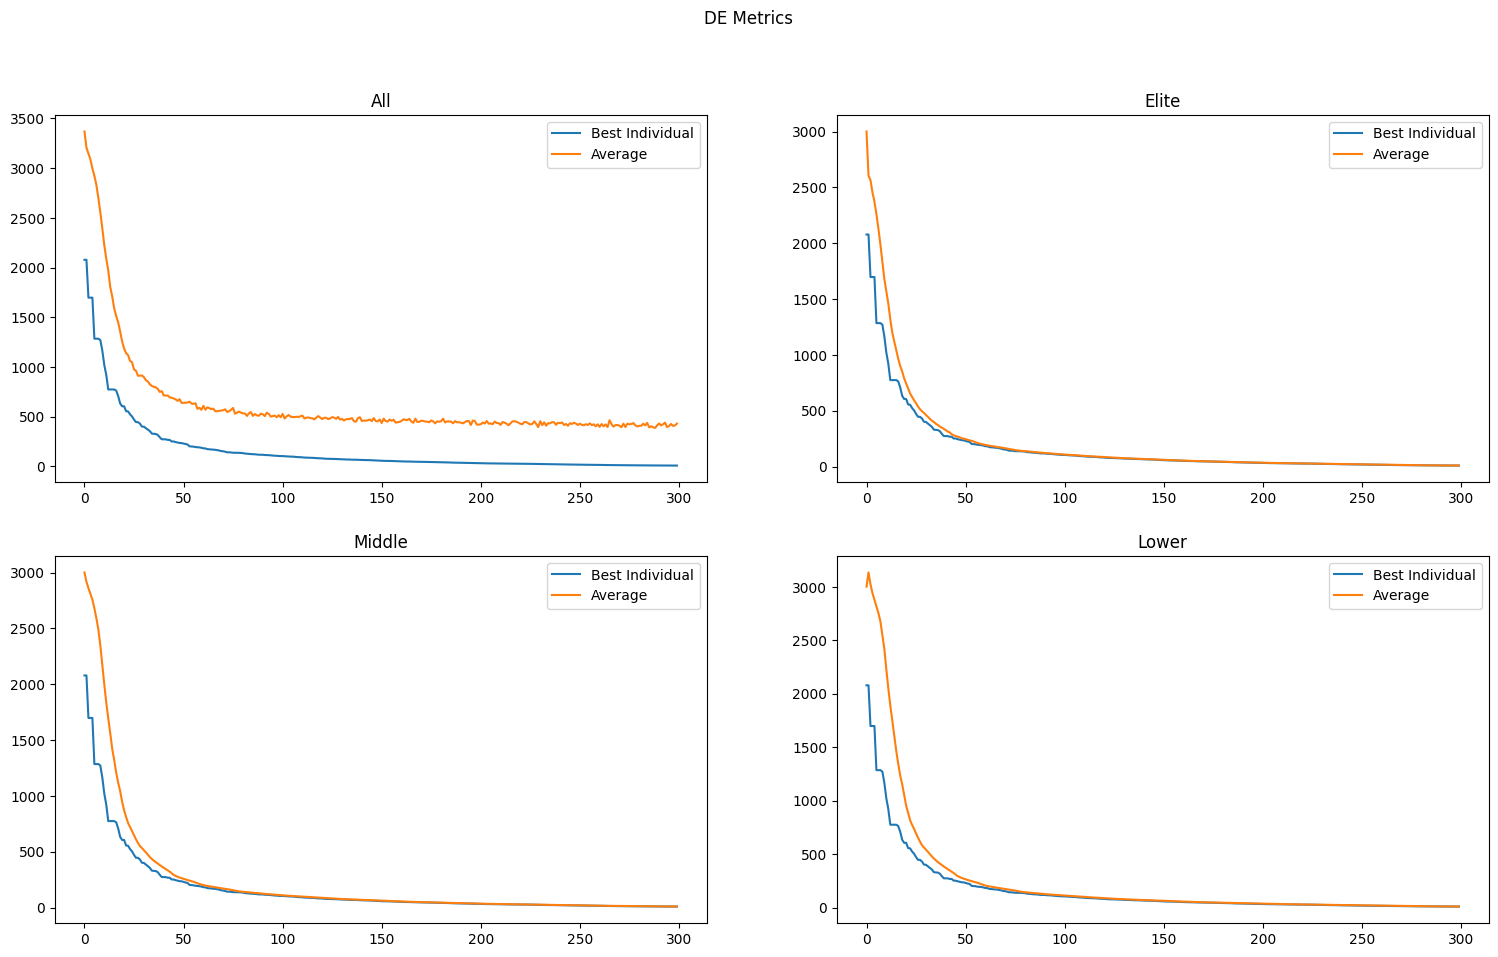

(array([-22.34622635,   5.83415544,  -5.86878885, -41.94164981,
          0.19296613, -14.86424337, -10.47075417,  -4.00140703,
        -19.14967779, -37.86368492,  -8.0166125 ,  13.40968153,
         10.69666267,  -3.4930435 ,  12.74795227,  -3.23310456,
         64.40978303,  -1.2943454 , -14.28216877,  24.97915016,
        -42.36503969,   4.98807627,   6.89804543,   1.60166679,
        -12.46919998,   5.67348418,  -2.72091601,  -8.75317744,
         19.32835437,  25.19608329,  -4.46389278,  15.62659706,
         14.11612964,  -1.30673093, -23.80207454,  15.24600784,
        -11.807155  ,  22.8554862 ,  -0.61522569,  -3.7970893 ,
         -0.26530678,  12.91686806,   5.5498679 ,  -6.41529123,
        -18.14209225, -46.08895674,  -0.75258331, -13.1620953 ,
          2.32404216,  12.61785475,  -6.62024772,   4.83828687,
         11.28743241,  20.09833383,   1.53756803,  19.35859218,
        -10.46660425,  -1.99643212,   7.09454377,  14.89011978,
         16.88442521,  -3.30498391, -11.

In [230]:
def func_8(x: np.ndarray):
    cost = 1/4000 * np.sum(np.apply_along_axis(lambda y: y**2, 0, x))
    prod = 1
    for i in range(x.shape[0]):
        prod *= np.cos(x[i] / np.sqrt(i + 1))
    return cost - prod + 1

metric_8 = MetricCollector()
d = 100
bounds = [(-600, 600) for _ in range(d)]
elite_pop_size = 50
middle_pop_size = 150
lower_pop_size = 100
F1 = 0.5
F2 = 0.5
F3 = 0.5
res = ttp_de(
    f=func_8,
    elite_pop_size=elite_pop_size,
    middle_pop_size=middle_pop_size,
    lower_pop_size=lower_pop_size,
    pop_initializer=latin(d, bounds),
    F1=F1,
    F2=F2,
    F3=F3,
    crossover_prob=0.5,
    crossover_func=binomial_crossover,
    n_iter=n_iters,
    metric=metric_8,
    T=500,
    alpha=0.9
)
metric_8.compile_graphs()
res

Iteration 0: 2.676481253803446 0.9 0.9
Iteration 10: 0.1505428231436037 0.81 0.9
Iteration 20: 0.013931903022930632 0.7290000000000001 0.9
Iteration 30: 0.0015298134925269317 0.6561000000000001 0.9
Iteration 40: 0.00019429532884180866 0.5904900000000002 0.9
Iteration 50: 5.7494212719516334e-05 0.5314410000000002 0.9
Iteration 60: 1.8717814781627188e-05 0.47829690000000014 0.9
Iteration 70: 7.78895650422577e-06 0.43046721000000016 0.9
Iteration 80: 3.861375097938224e-06 0.38742048900000015 0.9
Iteration 90: 1.4805797227633315e-06 0.34867844010000015 0.9
Iteration 100: 9.216082597909672e-07 0.31381059609000017 0.9
Iteration 110: 4.6591805306631936e-07 0.28242953648100017 0.9
Iteration 120: 2.966759039315065e-07 0.25418658283290013 0.9
Iteration 130: 2.0537050110071704e-07 0.22876792454961012 0.9
Iteration 140: 1.1844070057533174e-07 0.2058911320946491 0.9
Iteration 150: 7.697673112949787e-08 0.1853020188851842 0.9
Iteration 160: 5.154698974248602e-08 0.16677181699666577 0.9
Iteration 170

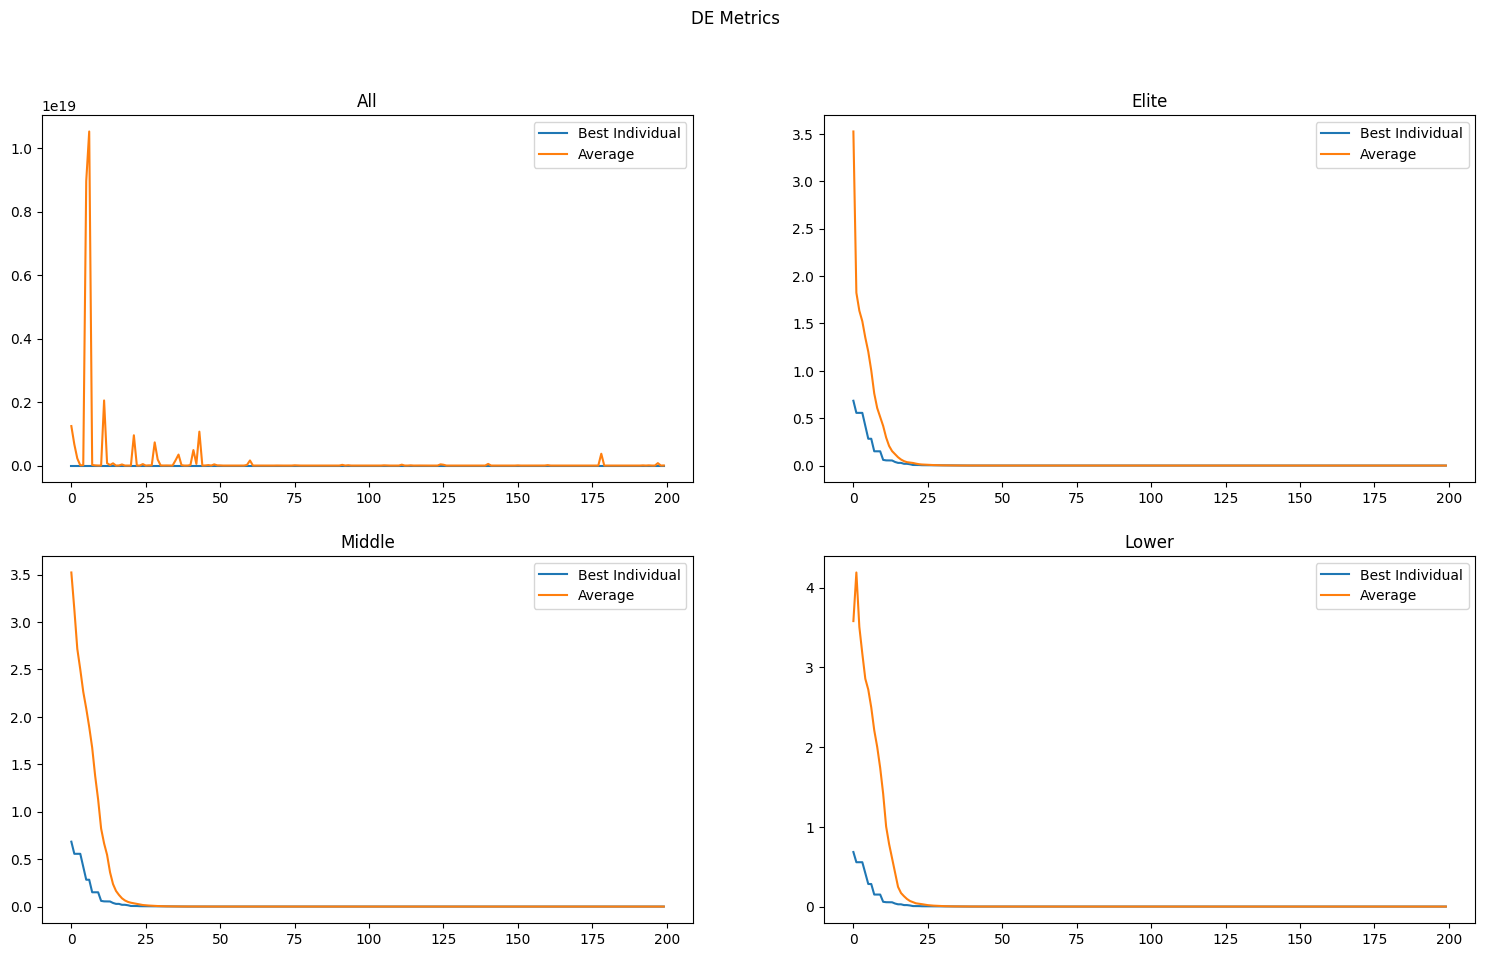

(array([-9.28090472e-11,  1.02305940e-06, -1.65323199e-04,  2.29585105e-04,
        -2.41190195e-03, -1.82691612e-02,  2.50879705e-02,  5.38513973e-02,
        -8.89676159e-02,  1.05238127e-01, -1.37995455e-01, -9.67503621e-02,
         1.74228561e-01, -2.00076473e-01, -3.77106356e-03, -8.01568604e-02,
        -1.77526804e-01, -2.23823041e-01, -9.35168096e-02, -6.72047349e-02,
        -2.74917730e-01, -2.74941793e-02,  3.08434919e-03,  1.09037919e-01,
         3.36608217e-01,  1.28128460e-01,  1.67045775e-01, -3.93474432e-01,
         1.19905054e-01,  7.85299990e-02,  5.08135964e-01,  5.01086599e-01,
        -4.38300704e-01, -5.03088179e-01,  8.73320571e-02, -4.45110125e-01,
        -4.93325381e-01, -4.08868071e-01,  5.44604867e-01,  7.60143593e-02,
        -3.46993652e-01, -2.69177628e-01,  4.53721555e-02,  2.72169087e-01,
        -2.25007775e-01,  5.02862133e-01,  4.33492868e-01, -2.39468183e-01,
        -4.82395651e-01, -4.99131573e-01]),
 2.5321008110677757e-09)

In [231]:
def func_9(x: np.ndarray):
    cost = 0
    for i in range(x.shape[0]):
        cost += np.abs(x[i]) ** (i + 1)
    return cost

metric_9 = MetricCollector()
d = 50
bounds = [(-1, 1) for _ in range(d)]
n_iters = 200
elite_pop_size = 50
middle_pop_size = 150
lower_pop_size = 100
F1 = 0.2
F2 = 0.6
F3 = 1
res = ttp_de(
    f=func_9,
    elite_pop_size=elite_pop_size,
    middle_pop_size=middle_pop_size,
    lower_pop_size=lower_pop_size,
    pop_initializer=latin(d, bounds),
    F1=F1,
    F2=F2,
    F3=F3,
    crossover_prob=0.5,
    crossover_func=binomial_crossover,
    n_iter=n_iters,
    metric=metric_9,
    T=1,
    alpha=0.9
)
metric_9.compile_graphs()
res

Iteration 0: 0.05815049807694658 9.0 0.9
Iteration 10: -4.277123792702076 8.1 0.9
Iteration 20: -5.939290695263 7.29 0.9
Iteration 30: -6.9381465801349425 6.561 0.9
Iteration 40: -7.961394164942145 5.9049000000000005 0.9
Iteration 50: -8.81309808809397 5.3144100000000005 0.9
Iteration 60: -9.15770925707936 4.7829690000000005 0.9
Iteration 70: -9.543247284709498 4.3046721 0.9
Iteration 80: -9.621202277021855 3.8742048900000006 0.9
Iteration 90: -9.666256281818532 3.4867844010000004 0.9
Iteration 100: -9.693681242967829 3.1381059609000004 0.9
Iteration 110: -9.72787944771927 2.82429536481 0.9
Iteration 120: -9.747360451820839 2.541865828329 0.9
Iteration 130: -9.751050132329365 2.2876792454961 0.9
Iteration 140: -9.751411790836652 2.05891132094649 0.9
Iteration 150: -9.751426470787285 1.853020188851841 0.9
Iteration 160: -9.751427374688163 1.6677181699666568 0.9
Iteration 170: -9.751427479865525 1.5009463529699911 0.9
Iteration 180: -9.751427490576155 1.350851717672992 0.9
Iteration 190:

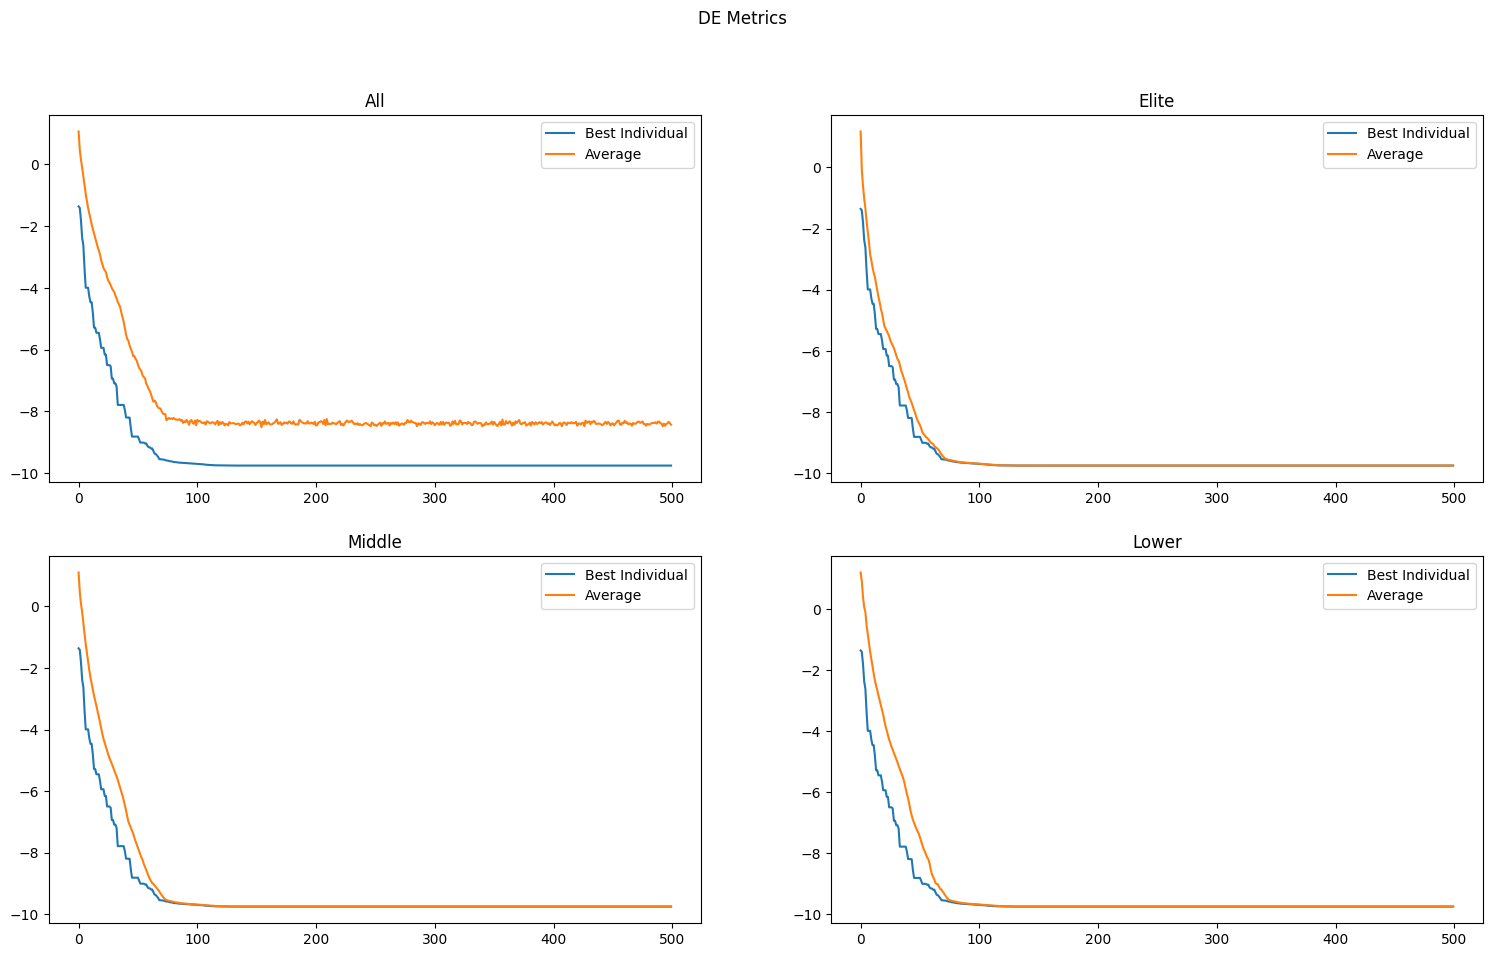

(array([ 4.96599768, -1.57079633,  4.96714945,  5.08984384, -1.72046977,
        -1.57079633, 10.97953439,  4.51178821, -1.28282401, -1.85848559]),
 -9.751427491212295)

In [232]:
def func_10(x: np.ndarray):
    cost = 0
    for i in range(x.shape[0]):
        cost += np.sin(x[i]) * (np.sin((i + 1) * x[i]**2 / np.pi)) ** (2 * 10)
    return cost

metric_10 = MetricCollector()
d = 10
bounds = [(0, np.pi) for _ in range(d)]
elite_pop_size = 50
middle_pop_size = 350
lower_pop_size = 100
n_iters=500
F1 = 0.1
F2 = 0.4
F3 = 0.8
res = ttp_de(
    f=func_10,
    elite_pop_size=elite_pop_size,
    middle_pop_size=middle_pop_size,
    lower_pop_size=lower_pop_size,
    pop_initializer=latin(d, bounds),
    F1=F1,
    F2=F2,
    F3=F3,
    crossover_prob=0.5,
    crossover_func=binomial_crossover,
    n_iter=n_iters,
    metric=metric_10,
    T=10,
    alpha=0.9
)
metric_10.compile_graphs()
res

In [233]:
def func_13(x: np.ndarray):
    cost = 0
    for i in range(x.shape[0]):
        for k in range(21):
            cost += 0.5**k * np.cos(2 * np.pi * 3**k * (x[i] + 0.5))
    return cost

metric_13 = MetricCollector()
d = 50
bounds = [(-10, 10) for _ in range(d)]
elite_pop_size = 50
middle_pop_size = 100
lower_pop_size = 50
n_iters=200
F1 = 0.1
F2 = 0.5
F3 = 1.2
res = ttp_de(
    f=func_13,
    elite_pop_size=elite_pop_size,
    middle_pop_size=middle_pop_size,
    lower_pop_size=lower_pop_size,
    pop_initializer=latin(d, bounds),
    F1=F1,
    F2=F2,
    F3=F3,
    crossover_prob=0.7,
    crossover_func=binomial_crossover,
    n_iter=n_iters,
    metric=metric_13,
    T=5,
    alpha=0.8
)
metric_13.compile_graphs()
res

Iteration 0: -3.503930236702439 4.0 0.8
Iteration 10: -23.451452043691443 3.2 0.8
Iteration 20: -25.685058028390273 2.5600000000000005 0.8
Iteration 30: -27.417542288764054 2.0480000000000005 0.8
Iteration 40: -27.417542288764054 1.6384000000000005 0.8
Iteration 50: -30.561676098265934 1.3107200000000006 0.8
Iteration 60: -30.561676098265934 1.0485760000000004 0.8
Iteration 70: -31.42550757011159 0.8388608000000004 0.8
Iteration 80: -37.82172822745577 0.6710886400000003 0.8
Iteration 90: -42.34975725018416 0.5368709120000003 0.8
Iteration 100: -43.789951196678786 0.42949672960000024 0.8
Iteration 110: -45.03602981213532 0.3435973836800002 0.8
Iteration 120: -46.58351589885578 0.27487790694400016 0.8
Iteration 130: -47.051250426144996 0.21990232555520015 0.8
Iteration 140: -47.5731006286915 0.17592186044416014 0.8


KeyboardInterrupt: 